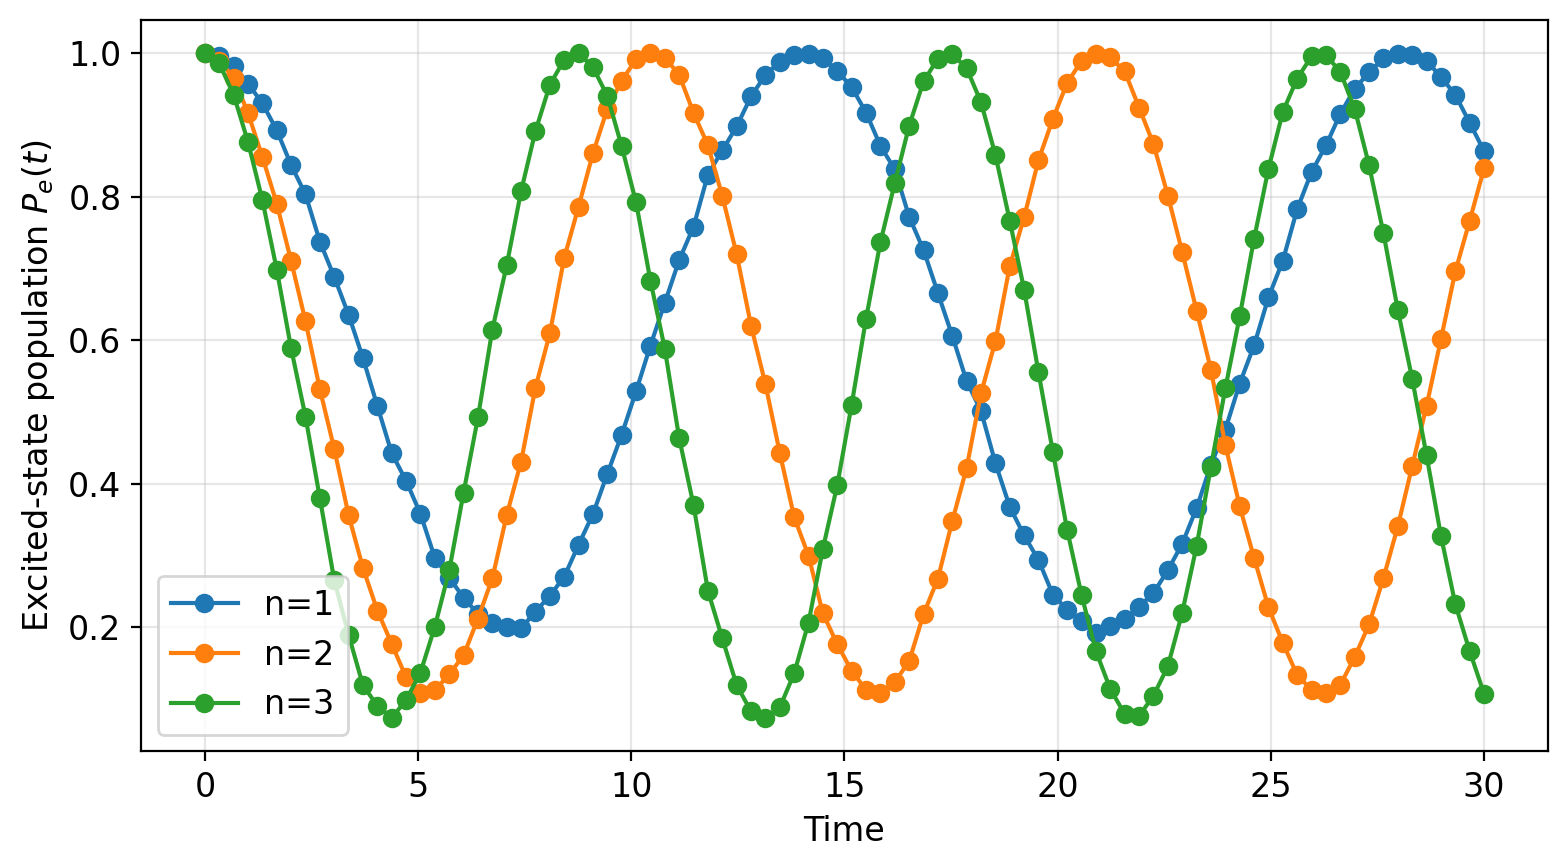

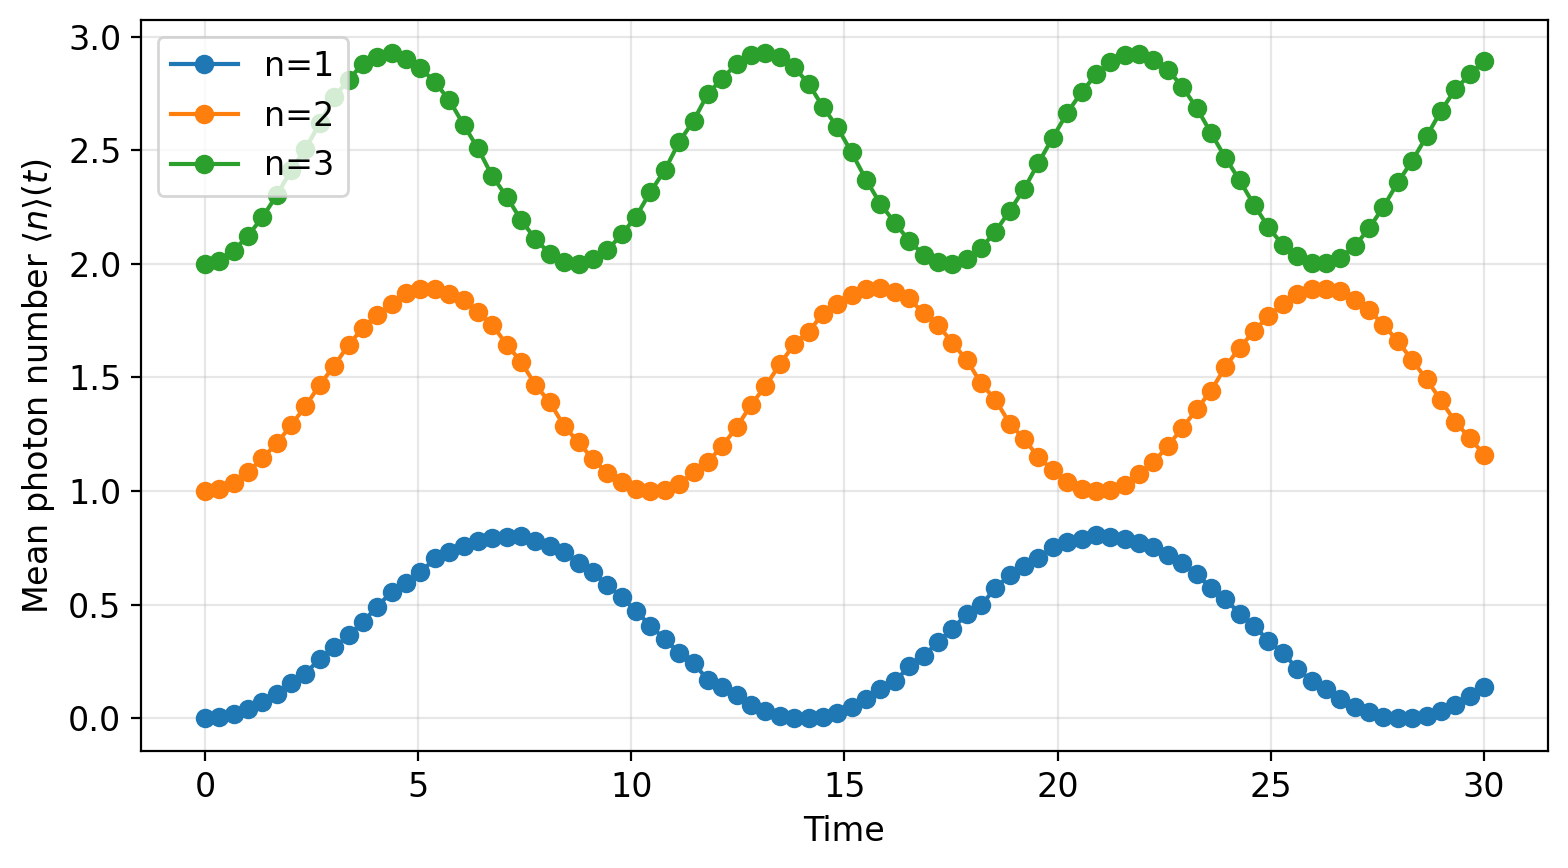

Saved figures: figures\jc_trotter_counts_Pe.pdf figures\jc_trotter_counts_nmean.pdf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

from utils.PauliGadget import trotter_1order

from utils.JC import H_eff_matrix, pauli_coeffs_from_2x2

omega_c = 1.2  # cavity freq 
omega_a = 1.0  # atom freq 
g = 0.2        # coupling strength 

sectors = [1, 2, 3]                 # total excitation sectors to simulate
tmax = 30.0                          
n_time_points = 90                 
times = np.linspace(0.0, tmax, n_time_points)

trotter_steps = 50                 
shots = 5000                         
backend = AerSimulator()           
outdir = "figures"
os.makedirs(outdir, exist_ok=True)

circuits = []
metadata = []  

for n in sectors:
    H = H_eff_matrix(n, omega_c, omega_a, g)
    c0, cx, cz = pauli_coeffs_from_2x2(H)

    pauli_list = [('I', c0), ('X', cx), ('Z', cz)]
    sparse = SparsePauliOp.from_list(pauli_list)

    for t in times:
        qc = QuantumCircuit(1, 1)   
        qc.name = f"JC_n{n}_t{t:.3f}"

        # Initial state: |0> represents |e, n-1> (excited atom, n-1 photons)

        trotter_1order(qc, [0], sparse, time=t, trotter_steps=trotter_steps)

        qc.measure(0, 0)

        circuits.append(qc)
        metadata.append((n, t))

qc_transpiled = transpile(circuits, backend=backend)
job = backend.run(qc_transpiled, shots=shots)
result = job.result()
all_counts = result.get_counts()  


Pe_data = {n: np.zeros_like(times) for n in sectors}   # excited-state population
nmean_data = {n: np.zeros_like(times) for n in sectors}  # mean photon number

for idx, counts in enumerate(all_counts):
    n, t = metadata[idx]
    n0 = counts.get('0', 0)
    P_e = float(n0) / float(shots)
    nmean = n - P_e

    t_index = np.argmin(np.abs(times - t))
    Pe_data[n][t_index] = P_e
    nmean_data[n][t_index] = nmean


plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(8,4.5), dpi=200)
for n in sectors:
    plt.plot(times, Pe_data[n], marker='o', label=f"n={n}")
plt.xlabel("Time")
plt.ylabel(r"Excited-state population $P_e(t)$")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
fname_pe = os.path.join(outdir, "jc_trotter_counts_Pe.pdf")
plt.savefig(fname_pe)
plt.show()

plt.figure(figsize=(8,4.5), dpi=200)
for n in sectors:
    plt.plot(times, nmean_data[n], marker='o', label=f"n={n}")
plt.xlabel("Time")
plt.ylabel(r"Mean photon number $\langle n\rangle(t)$")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
fname_nmean = os.path.join(outdir, "jc_trotter_counts_nmean.pdf")
plt.savefig(fname_nmean)
plt.show()

print("Saved figures:", fname_pe, fname_nmean)


Generating plot for wa=1.0...
Generating plot for wa=1.3...
Saved figure to figures\jc_noisy_Pe.pdf


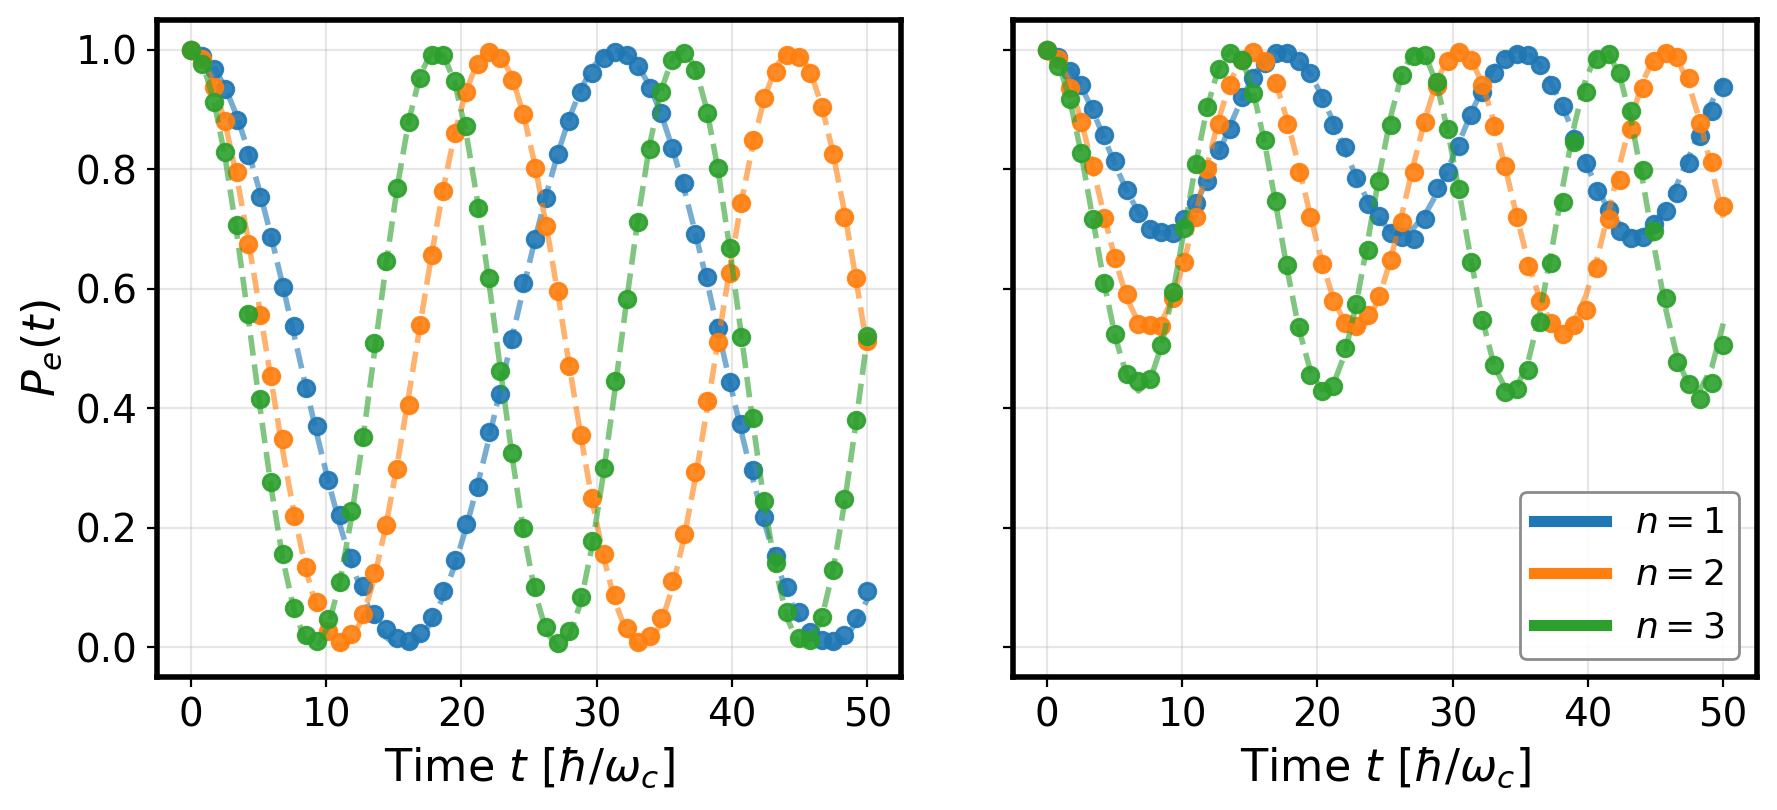

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt
from scipy.linalg import expm
from matplotlib.lines import Line2D

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error

from utils.PauliGadget import trotter_1order
from utils.JC import H_eff_matrix, get_pauli_op, get_exact_solution

def run_simulation(n, wa, noise_model):
    H = H_eff_matrix(n, omega_c, wa, g)
    op = get_pauli_op(H)
    circuits = []
    times = np.linspace(0, tmax, steps)
    for t in times:
        qc = QuantumCircuit(1, 1)
        trotter_1order(qc, [0], op, t, trotter_steps)
        qc.measure(0, 0)
        circuits.append(qc)
    backend = AerSimulator(noise_model=noise_model)
    qc_transpiled = transpile(circuits, backend=backend, optimization_level=1)
    counts = backend.run(qc_transpiled, shots=shots).result().get_counts()
    pe_sim = [c.get('0', 0)/shots for c in counts]
    pe_exact = get_exact_solution(H, times)
    return times, pe_sim, pe_exact

from utils.Circuit_helpers import get_noise_model

outdir = "figures"
os.makedirs(outdir, exist_ok=True)

omega_c = 1.0       # Cavity frequency
g = 0.1             # Coupling
tmax = 50.0         # Max time
steps = 60          # Time points
trotter_steps = 30  
shots = 5000        

sectors = [1, 2, 3] 
colors = ['tab:blue', 'tab:orange', 'tab:green'] 



plt.rcParams.update({
    'font.size': 14,          
    'axes.titlesize': 16,     
    'axes.labelsize': 16,    
    'xtick.labelsize': 14,   
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'lines.linewidth': 2.0,   
    'lines.markersize': 6     
})

conditions = [
    {"wa": 1.0}, # Resonant
    {"wa": 1.3}  # Detuned
]

noise_inst = get_noise_model(t1=40, t2=25)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=200, sharey=True)
plt.subplots_adjust(wspace=0.15, bottom=0.15, left=0.10) 

for i, cond in enumerate(conditions):
    ax = axes[i]
    print(f"Generating plot for wa={cond['wa']}...")
    
    for j, n in enumerate(sectors):
        times, sim, exact = run_simulation(n, cond['wa'], noise_inst)
        col = colors[j]
        
        ax.plot(times, exact, linestyle='--', color=col, alpha=0.6)
        ax.plot(times, sim, marker='o', linestyle='None', color=col, alpha=0.9)

    ax.set_xlabel(r"Time $t$ [$\hbar/\omega_c$]")
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.set_ylabel(r"$P_e(t)$")
        
    if i == 1:
        legend_elements = [
            Line2D([0], [0], color=colors[0], lw=4, label='$n=1$'),
            Line2D([0], [0], color=colors[1], lw=4, label='$n=2$'),
            Line2D([0], [0], color=colors[2], lw=4, label='$n=3$')
        ]
        ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9, edgecolor='gray')

fname = os.path.join(outdir, "jc_noisy_Pe.pdf")
plt.savefig(fname, bbox_inches='tight')
print(f"Saved figure to {fname}")
plt.show()

Generating plot for wa=1.0...
Generating plot for wa=1.3...
Saved figure to figures\jc_noisy_nmean.pdf


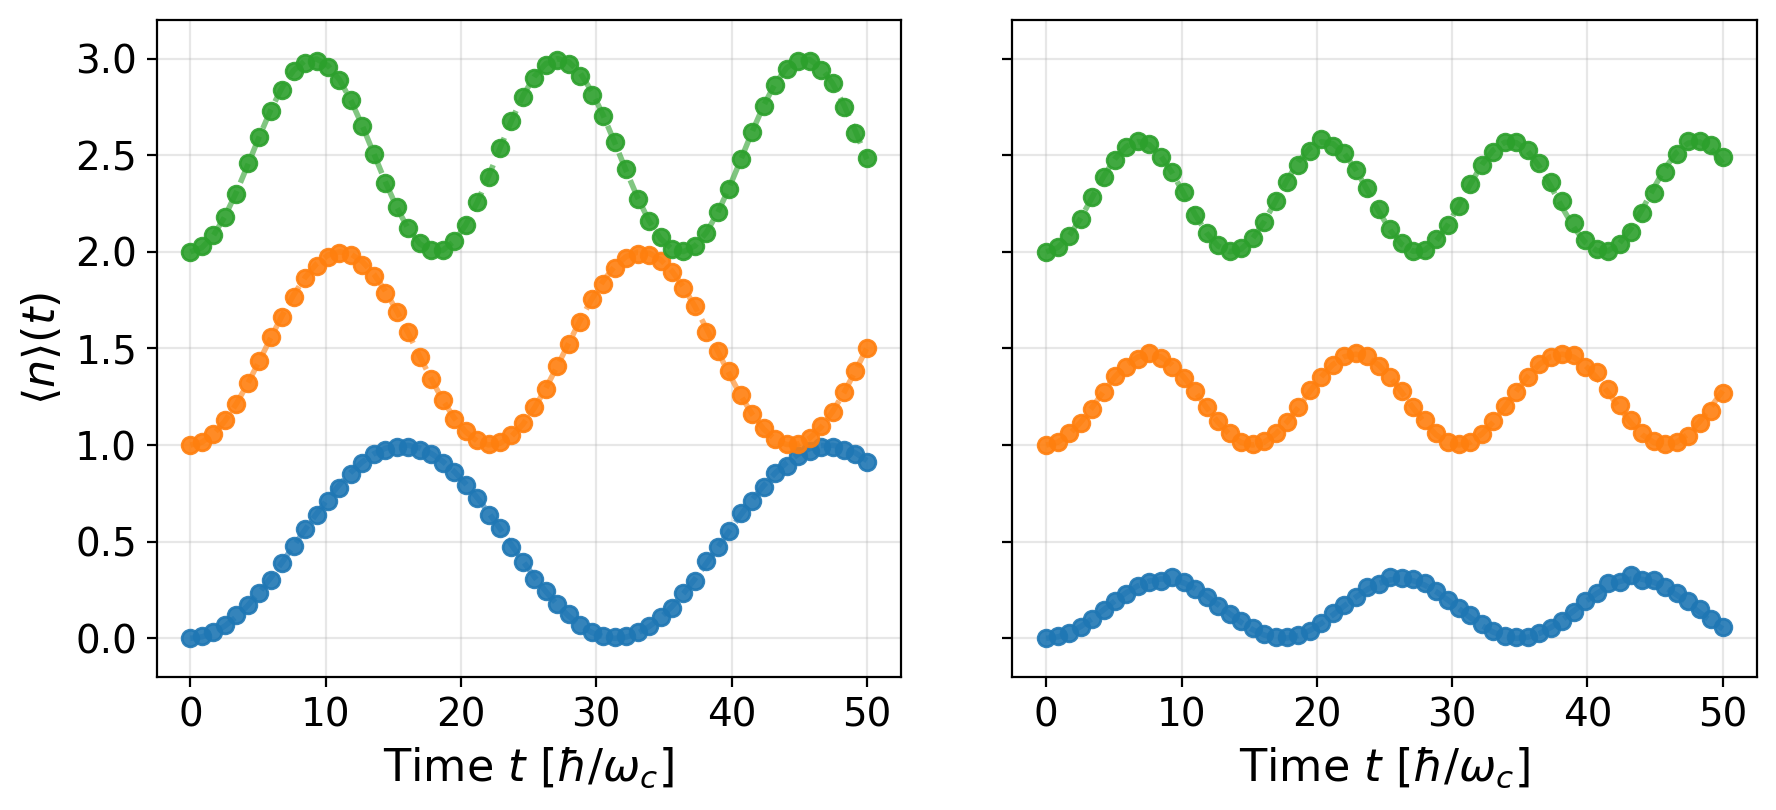

In [38]:
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'lines.linewidth': 2.0,
    'lines.markersize': 6
})

conditions = [
    {"wa": 1.0}, # Resonant
    {"wa": 1.3}  # Detuned
]

sectors = [1, 2, 3] 
colors = ['tab:blue', 'tab:orange', 'tab:green']

noise_inst = get_noise_model(t1=40, t2=25)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=200, sharey=True)
plt.subplots_adjust(wspace=0.15, bottom=0.15, left=0.10) 

for i, cond in enumerate(conditions):
    ax = axes[i]
    print(f"Generating plot for wa={cond['wa']}...")
    
    for j, n in enumerate(sectors):
        times, pe_sim, pe_exact = run_simulation(n, cond['wa'], noise_inst)
        
        n_mean_sim = n - np.array(pe_sim)
        n_mean_exact = n - pe_exact 
        col = colors[j]
        
        ax.plot(times, n_mean_exact, linestyle='--', color=col, alpha=0.6)
        ax.plot(times, n_mean_sim, marker='o', linestyle='None', color=col, alpha=0.9)
    
    ax.set_xlabel(r"Time $t$ [$\hbar/\omega_c$]")
    ax.set_ylim(-0.2, 3.2)
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.set_ylabel(r"$\langle n \rangle(t)$")
        

fname = os.path.join(outdir, "jc_noisy_nmean.pdf")
plt.savefig(fname, bbox_inches='tight')
print(f"Saved figure to {fname}")
plt.show()

In [ ]:
import math
from utils.Truncation import exact_truncation_N
examples = [
    (2.6, 1e-1),
    (3.0, 1e-1),
    (4.0, 1e-1),
    (8.4, 1e-1),
    (8.0, 1e-2),
    (9.0, 1e-1),
    (20.0, 1e-2),
]

for mu, eps in examples:
    N = exact_truncation_N(mu, eps, use_half=True)
    p = math.exp(-mu)
    cum = p
    for k in range(1, N):
        p = p * (mu / k)
        cum += p
    tail = 1.0 - cum
    print(f"mu={mu:>5g}, epsilon={eps:.1e} -> N={N:>4d}, tail={tail:.3e} (target {eps/2:.3e})")


mu=  2.6, epsilon=1.0e-01 -> N=   6, tail=4.904e-02 (target 5.000e-02)
mu=    3, epsilon=1.0e-01 -> N=   7, tail=3.351e-02 (target 5.000e-02)
mu=    4, epsilon=1.0e-01 -> N=   9, tail=2.136e-02 (target 5.000e-02)
mu=  8.4, epsilon=1.0e-01 -> N=  14, tail=4.756e-02 (target 5.000e-02)
mu=    8, epsilon=1.0e-02 -> N=  17, tail=3.718e-03 (target 5.000e-03)
mu=    9, epsilon=1.0e-01 -> N=  15, tail=4.147e-02 (target 5.000e-02)
mu=   20, epsilon=1.0e-02 -> N=  33, tail=4.727e-03 (target 5.000e-03)


--- Cutoff Determination (Theorem II.1) ---
Error tolerance (epsilon): 0.1
Required Tail Bound (epsilon/2): 0.05000

Alpha: 2.0 (Mean n=4.0)
  -> Initial Tail Cutoff (Thm II.1): N = 9
  -> Tail Weight: 2.14e-02
  -> Recommended Simulation Cutoff (+1 buffer): 10

Alpha: 3.0 (Mean n=9.0)
  -> Initial Tail Cutoff (Thm II.1): N = 15
  -> Tail Weight: 4.15e-02
  -> Recommended Simulation Cutoff (+1 buffer): 16

Alpha: 4.0 (Mean n=16.0)
  -> Initial Tail Cutoff (Thm II.1): N = 24
  -> Tail Weight: 3.67e-02
  -> Recommended Simulation Cutoff (+1 buffer): 25



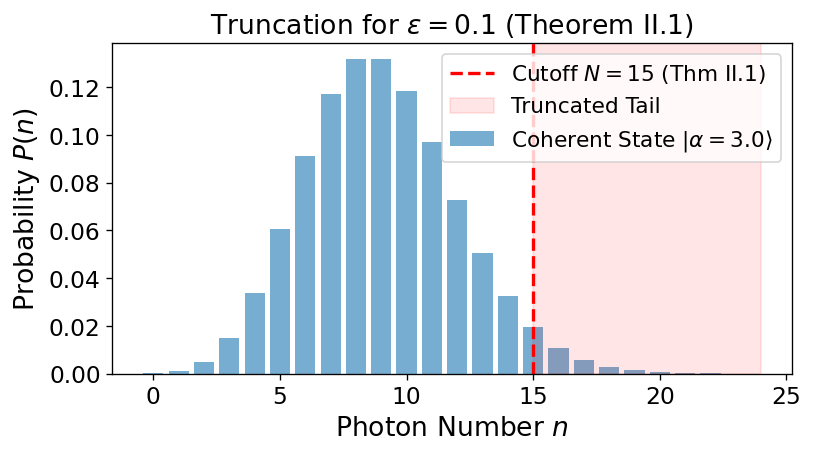

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

from utils.Truncation import find_cutoff_coherent

alpha_values = [2.0, 3.0, 4.0] # Corresponds to <n> = 4, 9, 16
epsilon = 0.1                 # 1% error tolerance

print(f"--- Cutoff Determination (Theorem II.1) ---")
print(f"Error tolerance (epsilon): {epsilon}")
print(f"Required Tail Bound (epsilon/2): {epsilon/2:.5f}\n")

for alpha in alpha_values:
    N, tail = find_cutoff_coherent(alpha, epsilon)
    N_total = N + 1 
    
    print(f"Alpha: {alpha} (Mean n={alpha**2})")
    print(f"  -> Initial Tail Cutoff (Thm II.1): N = {N}")
    print(f"  -> Tail Weight: {tail:.2e}")
    print(f"  -> Recommended Simulation Cutoff (+1 buffer): {N_total}\n")

# --- Visualization of the Tail ---
alpha_plot = 3.0 
mean_n = alpha_plot**2
x_max = int(mean_n + 5 * np.sqrt(mean_n)) 
n_range = np.arange(0, x_max)
probs = poisson.pmf(n_range, mean_n)

cutoff, _ = find_cutoff_coherent(alpha_plot, epsilon)

plt.figure(figsize=(7, 4), dpi=120)
plt.bar(n_range, probs, alpha=0.6, label=f"Coherent State |$\\alpha={alpha_plot}\\rangle$")
plt.axvline(cutoff, color='r', linestyle='--', label=f"Cutoff $N={cutoff}$ (Thm II.1)")
plt.axvspan(cutoff, x_max, color='r', alpha=0.1, label="Truncated Tail")

plt.xlabel("Photon Number $n$")
plt.ylabel("Probability $P(n)$")
plt.title(f"Truncation for $\\epsilon={epsilon}$ (Theorem II.1)")
plt.legend()
plt.tight_layout()
plt.show()

<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
C:\Users\dmra\AppData\Local\Temp\ipykernel_79064\1837738498.py:57: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f"Collapse and Revival Target ($\mu={mu}$)")


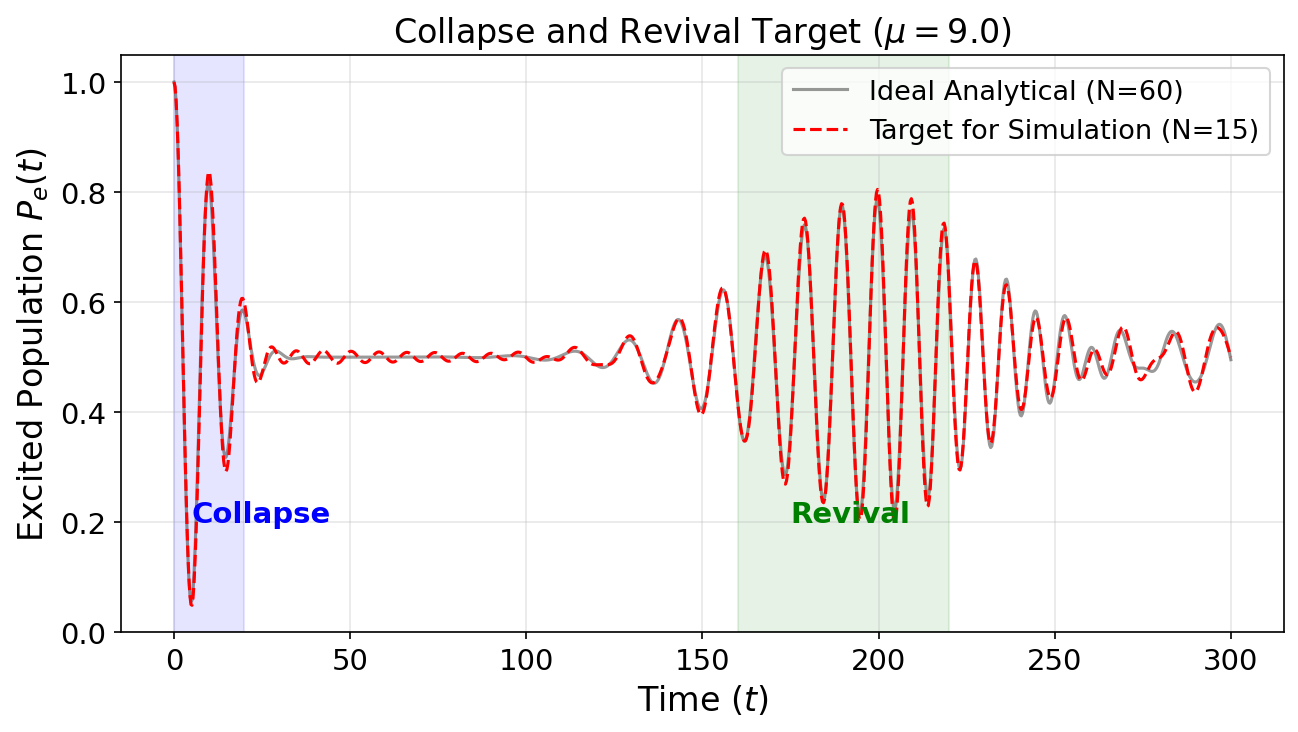

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, exp, sqrt

from utils.Truncation import get_Pe_coherent
g = 0.1
mu = 9.0          
alpha = sqrt(mu)
N_ideal = 60      
N_sim = 15        

t_max = 300.0       # Long enough to see revival
times = np.linspace(0, t_max, 1000)

Pe_ideal = get_Pe_coherent(times, mu, N_ideal)
Pe_trunc = get_Pe_coherent(times, mu, N_sim)

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(times, Pe_ideal, 'k-', linewidth=1.5, alpha=0.4, label=f"Ideal Analytical (N={N_ideal})")

plt.plot(times, Pe_trunc, 'r--', linewidth=1.5, label=f"Target for Simulation (N={N_sim})")

plt.title(f"Collapse and Revival Target ($\mu={mu}$)")
plt.xlabel("Time ($t$)")
plt.ylabel("Excited Population $P_e(t)$")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()

plt.axvspan(0, 20, color='blue', alpha=0.1)
plt.text(5, 0.2, "Collapse", color='blue', fontweight='bold')

plt.axvspan(160, 220, color='green', alpha=0.1)
plt.text(175, 0.2, "Revival", color='green', fontweight='bold')

plt.show()

In [ ]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator

from utils.JC import get_binary_jc_hamiltonian

H_binary = get_binary_jc_hamiltonian(N_cutoff=16, g=0.1, omega_c=1.0, omega_a=1.0)

print(f"Hamiltonian generated with {H_binary.num_qubits} qubits.")
print(f"Total number of Pauli strings: {len(H_binary)}")
print("\nSample of Interaction Terms (Looking for multi-qubit strings):")

for pauli, coeff in zip(H_binary.paulis, H_binary.coeffs):
    s_label = pauli.to_label()
    if 'X' in s_label[1:] or 'Y' in s_label[1:]:
        print(f"{s_label}: {coeff.real:.4f}")
        break 

Hamiltonian generated with 5 qubits.
Total number of Pauli strings: 80

Sample of Interaction Terms (Looking for multi-qubit strings):
IIIXX: 0.1338


Running Binary Simulation...


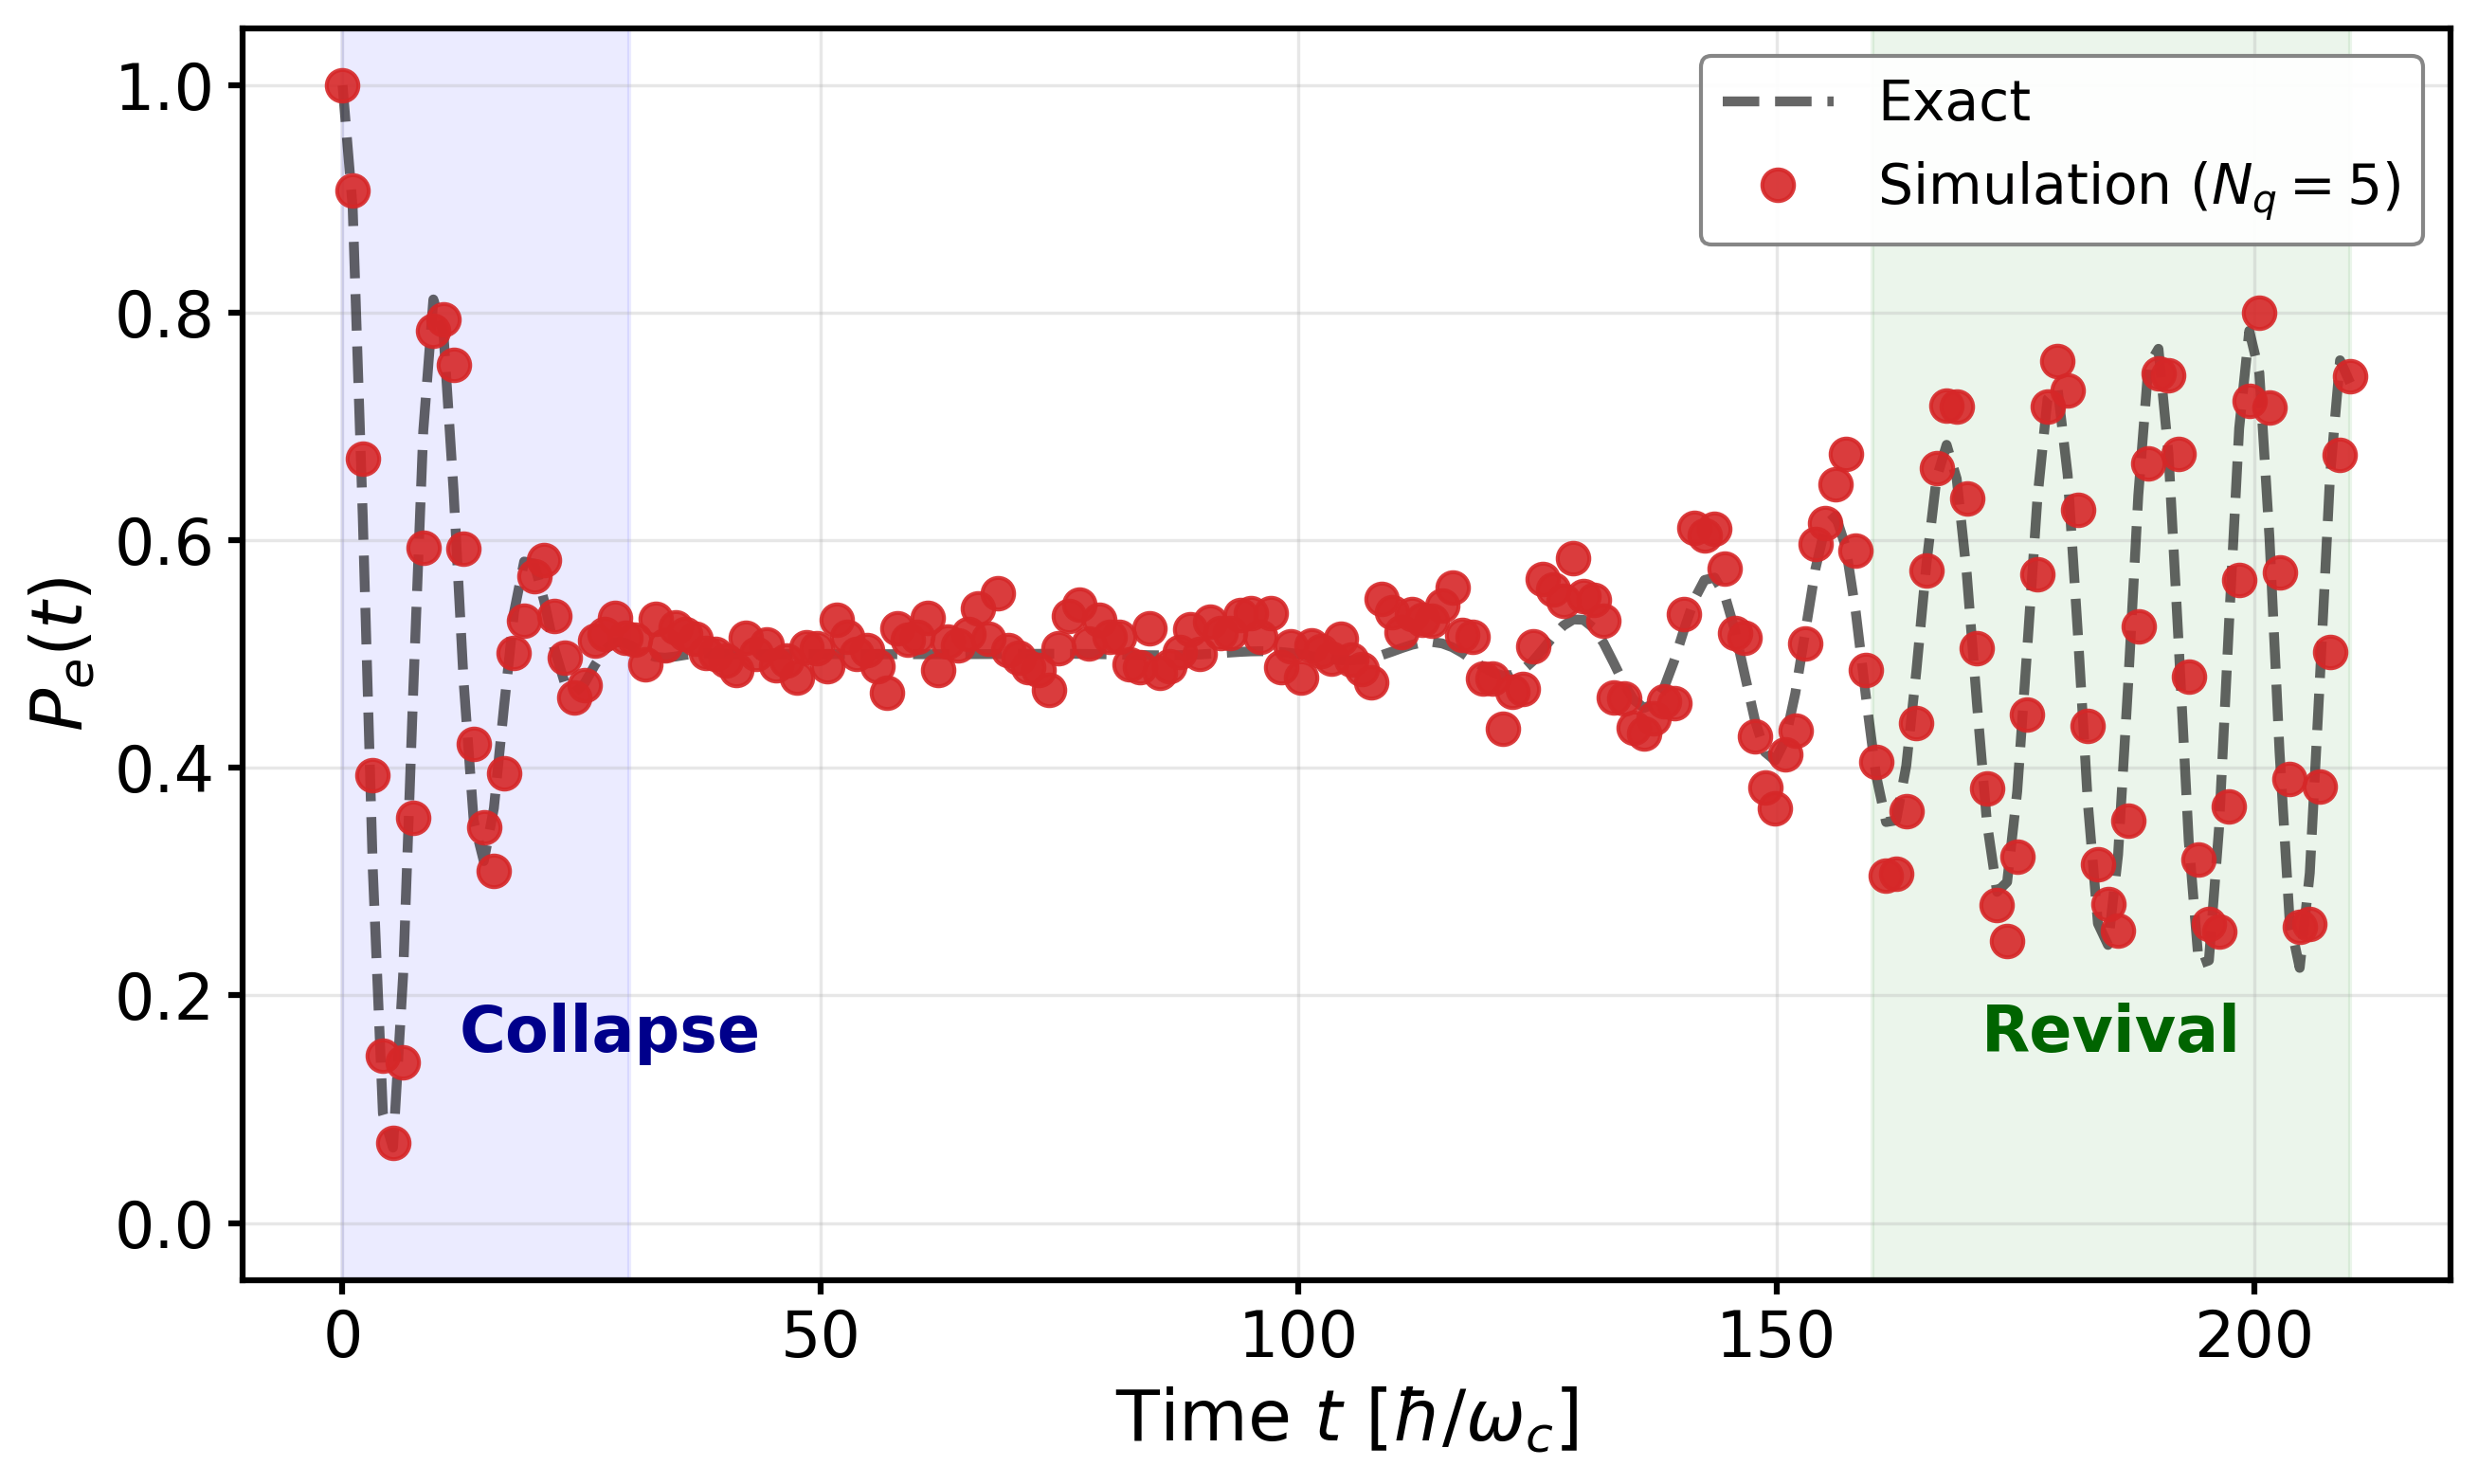

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, exp, sqrt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, exp, sqrt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector
from qiskit_aer import AerSimulator

from utils.JC import get_binary_jc_hamiltonian, get_initial_state, get_Pe_coherent_exact

omega_c = 1.0       # Cavity freq
omega_a = 1.0       # Atom freq (Resonant)
g = 0.1             # Coupling strength
mu = 9.0            # Mean photon number (alpha=3)
alpha_val = sqrt(mu)

N_cutoff = 16       
num_qubits = 5      # 4 cavity + 1 atom

t_max = 200.0
time_points = 50
times = np.linspace(0.001, t_max, time_points)


dt_target = 1
shots = 2000
backend = AerSimulator()

print("Constructing Binary Hamiltonian...")
H_binary = get_binary_jc_hamiltonian(N_cutoff, g, omega_c, omega_a)
print(f"Hamiltonian terms: {len(H_binary)}")



psi_init = get_initial_state(alpha_val, N_cutoff)

print("Starting Trotter Simulation (this may take a moment)...")
circuits = []

for t in times:
    qc = QuantumCircuit(num_qubits, 1) 
    
    qc.initialize(psi_init, range(num_qubits))
    
    steps = max(1, int(t / dt_target))
    
    trotter_1order(qc, range(num_qubits), H_binary, t, trotter_steps=steps)
    
    # Measure Atom (Qubit 4)
    qc.measure(4, 0) 
    circuits.append(qc)

qc_transpiled = transpile(circuits, backend=backend)
job = backend.run(qc_transpiled, shots=shots)
result = job.result()
counts_list = result.get_counts()

Pe_sim = []
for counts in counts_list:
    ne = counts.get('1', 0)
    Pe_sim.append(ne / shots)


Pe_exact = get_Pe_coherent_exact(times, mu)

plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.linewidth': 1.5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'legend.fontsize': 14,
    'lines.linewidth': 2.5,
    'lines.markersize': 8
})

plt.figure(figsize=(9, 5.5), dpi=300) 

plt.plot(times, Pe_exact, 'k--', alpha=0.6, label="Exact")
plt.plot(times, Pe_sim, 'o', color='tab:red', linestyle='None', alpha=0.9, label=r"Simulation ($N_q=5$)")

plt.xlabel(r"Time $t$ [$\hbar/\omega_c$]")
plt.ylabel(r"$P_e(t)$")
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.3)


plt.axvspan(0, 30, color='blue', alpha=0.08)

plt.text(28, 0.15, "Collapse", color='darkblue', fontweight='bold', ha='center', fontsize=16)

plt.axvspan(160, 210, color='green', alpha=0.08)
plt.text(185, 0.15, "Revival", color='darkgreen', fontweight='bold', ha='center', fontsize=16)

plt.legend(loc='upper right', framealpha=0.95, edgecolor='gray')

plt.tight_layout()
filename = "jc_collapse_revival.pdf"
plt.savefig(filename, bbox_inches='tight')
plt.show()

In [ ]:
import math

from utils.Truncation import compute_dynamical_cutoff


if __name__ == "__main__":
    examples = [
        # (mu, epsilon, t, g)
        (9.0, 0.1, 200.0, 0.1),  
        (4.0, 0.1, 1.0, 1.0),
        (4.0, 0.1, 5.0, 1.0),
        (25.0, 0.1, 1.0, 0.5),
    ]

    for mu, eps, t, g in examples:
        res = compute_dynamical_cutoff(mu=mu, epsilon=eps, t=t, g=g, C=1.0, chi=None, use_half=True)
        print("-----")
        print(f"mu={mu}, epsilon={eps}, t={t}, g={g}")
        print(f"  exact N (initial tail) = {res['N']}, tail_prob = {res['tail_prob']:.3e}")
        print(f"  Lambda0 = {res['Lambda0']}")
        print(f"  tildeLambda (continuous) = {res['tildeLambda_continuous']:.3f}")
        print(f"  tildeLambda (ceil int) = {res['tildeLambda_int']}")
        print(f"  recommended N_final = {res['N_final']}  (# qubits for field = ceil(log2(N_final)))")


-----
mu=9.0, epsilon=0.1, t=200.0, g=0.1
  exact N (initial tail) = 15, tail_prob = 4.147e-02
  Lambda0 = 14
  tildeLambda (continuous) = 31100.061
  tildeLambda (ceil int) = 31101
  recommended N_final = 31102  (# qubits for field = ceil(log2(N_final)))
-----
mu=4.0, epsilon=0.1, t=1.0, g=1.0
  exact N (initial tail) = 9, tail_prob = 2.136e-02
  Lambda0 = 8
  tildeLambda (continuous) = 62.467
  tildeLambda (ceil int) = 63
  recommended N_final = 64  (# qubits for field = ceil(log2(N_final)))
-----
mu=4.0, epsilon=0.1, t=5.0, g=1.0
  exact N (initial tail) = 9, tail_prob = 2.136e-02
  Lambda0 = 8
  tildeLambda (continuous) = 1314.170
  tildeLambda (ceil int) = 1315
  recommended N_final = 1316  (# qubits for field = ceil(log2(N_final)))
-----
mu=25.0, epsilon=0.1, t=1.0, g=0.5
  exact N (initial tail) = 34, tail_prob = 4.978e-02
  Lambda0 = 33
  tildeLambda (continuous) = 74.721
  tildeLambda (ceil int) = 75
  recommended N_final = 76  (# qubits for field = ceil(log2(N_final)))


Constructing Hamiltonians (N=64, 7 Qubits)...
Calculating Exact Solutions...
Running Rabi Simulation ...


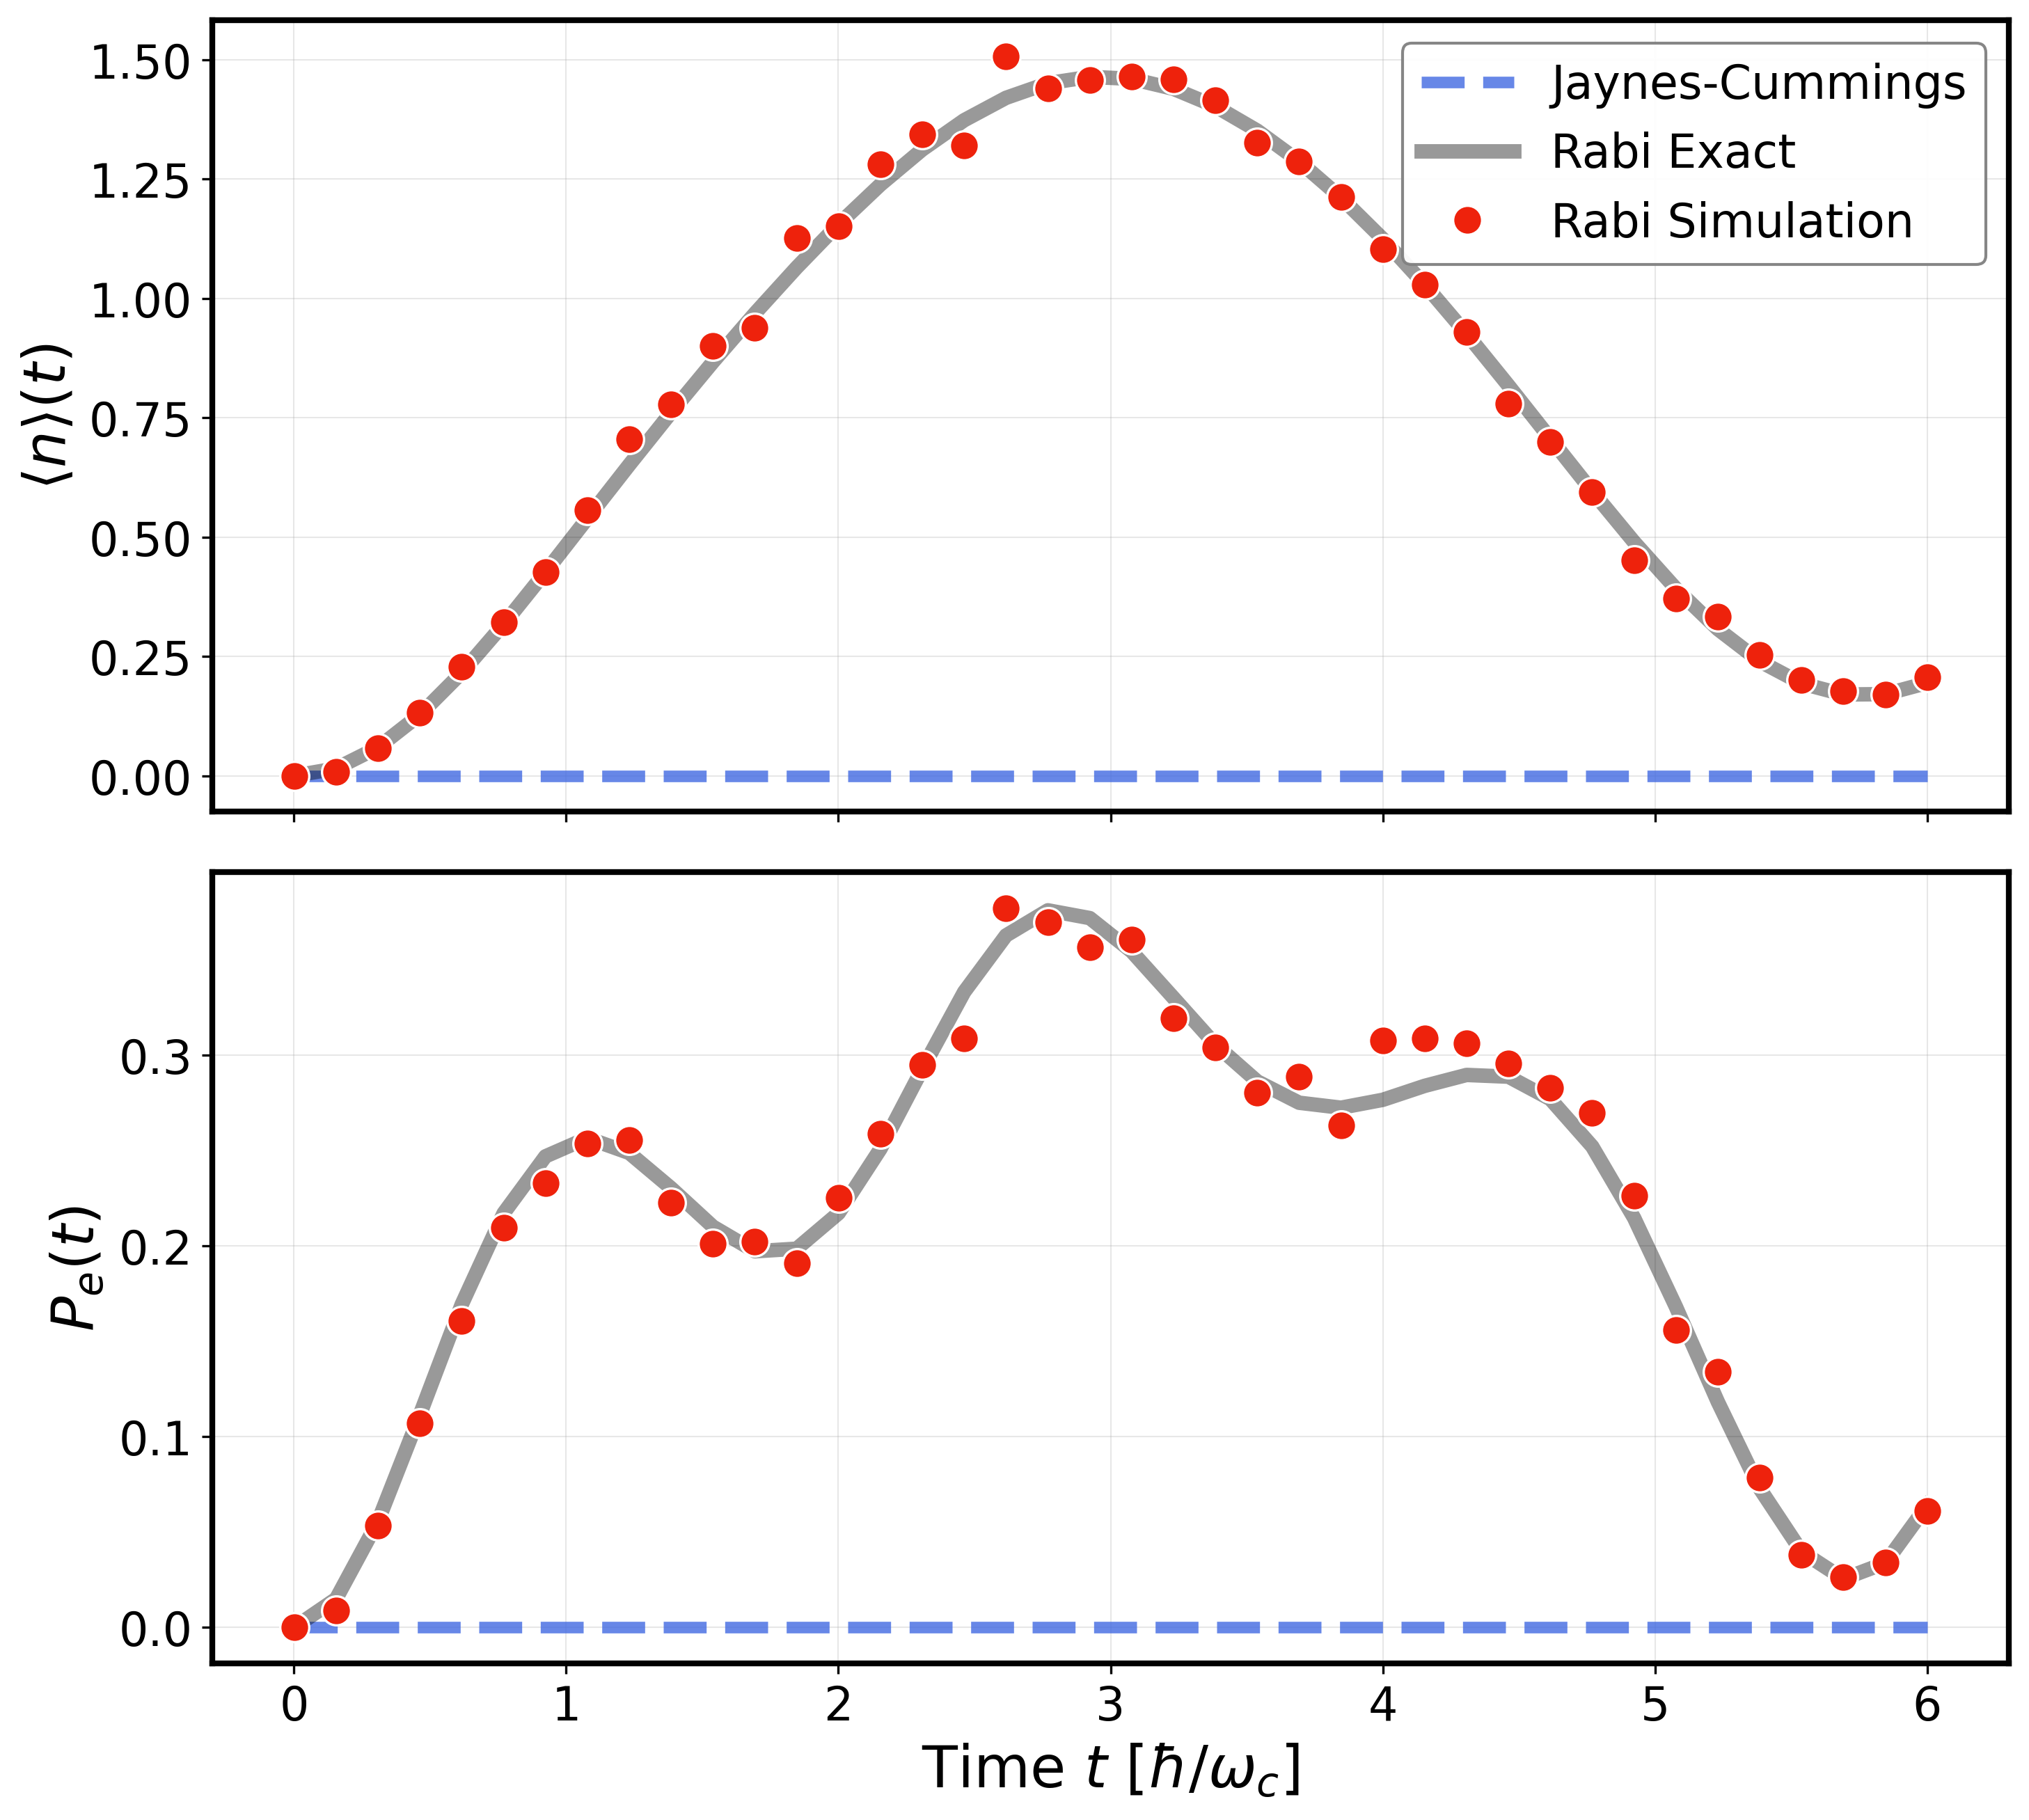

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_aer import AerSimulator

omega_c = 1.0       
omega_a = 1.0       
g_usc = 0.8         
N_cutoff = 64       
num_qubits = 7      
shots = 2048
t_max = 6.0         
time_points = 40    
times = np.linspace(0.001, t_max, time_points)

from utils.Circuit_helpers import run_trotter_sim
from utils.Rabi import get_binary_hamiltonian_rabi
from utils.Rabi import get_exact_dynamics

print("Constructing Hamiltonians (N=64, 7 Qubits)...")
H_op_rabi = get_binary_hamiltonian_rabi(N_cutoff, g_usc, omega_c, omega_a, 'rabi')
H_op_jc   = get_binary_hamiltonian_rabi(N_cutoff, g_usc, omega_c, omega_a, 'jc')

H_mat_rabi = H_op_rabi.to_matrix()
H_mat_jc   = H_op_jc.to_matrix()
psi0 = np.zeros(2**num_qubits); psi0[0] = 1.0 # |g, 0>

print("Calculating Exact Solutions...")
n_exact_rabi, pe_exact_rabi = get_exact_dynamics(H_mat_rabi, times, num_qubits, psi0)
n_exact_jc, pe_exact_jc     = get_exact_dynamics(H_mat_jc, times, num_qubits, psi0)

print("Running Rabi Simulation ...")
n_sim_rabi, pe_sim_rabi = run_trotter_sim(H_op_rabi, times)

plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 20,      
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,     
    'lines.linewidth': 4.0,    
    'lines.markersize': 10,    
    'axes.linewidth': 2.0      
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9), dpi=300, sharex=True)
plt.subplots_adjust(hspace=0.05) 


ax1.plot(times, n_exact_jc, color='royalblue', linestyle='--', alpha=0.8, 
         label='Jaynes-Cummings')

ax1.plot(times, n_exact_rabi, color='black', linestyle='-', alpha=0.4, linewidth=5, 
         label='Rabi Exact')

ax1.plot(times, n_sim_rabi, 'o', color='#EE220C', markeredgecolor='white', markeredgewidth=0.8, 
         alpha=1.0, label='Rabi Simulation')

ax1.set_ylabel(r"$\langle n \rangle(t)$")
ax1.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.legend(loc='upper right', framealpha=0.95, edgecolor='gray', fancybox=True)


ax2.plot(times, pe_exact_jc, color='royalblue', linestyle='--', alpha=0.8)

ax2.plot(times, pe_exact_rabi, color='black', linestyle='-', alpha=0.4, linewidth=5)

ax2.plot(times, pe_sim_rabi, 'o', color='#EE220C', markeredgecolor='white', markeredgewidth=0.8, 
         alpha=1.0)

ax2.set_ylabel(r"$P_e(t)$")
ax2.set_xlabel(r"Time $t$ [$\hbar/\omega_c$]")
ax2.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
filename = "rabi_leakage2.pdf"
plt.savefig(filename, bbox_inches='tight')
plt.show()